In [2]:
# import argparse
# ap = argparse.ArgumentParser(description="test")
# ap.add_argument('-l','--list', nargs='+', help='<Required> Set flag', required=True)
# args = ap.parse_args()

# model_names = args.list # we are going to assume that only one model is used each time for this script

model_names = ['Original_Pretrained_R2plus1DMotionSegNet.pth']

log_file_name = f"./warren-random/quantifying-performance/{model_names[0]}log.txt"

USE_CUSTOM_NUM_VIDS_TO_GO_THRU = True
CUSTOM_NUM_VIDS = 5

import os
os.chdir("/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking")

import sys
sys.path.append('/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking')
# print(os.getcwd())

# %config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

# v1 dropout, not in place dropout
from src.model.dropout_0_10_R2plus1D_18_MotionNet import dropout_0_10_R2plus1D_18_MotionNet
from src.model.dropout_0_25_R2plus1D_18_MotionNet import dropout_0_25_R2plus1D_18_MotionNet
from src.model.dropout_0_50_R2plus1D_18_MotionNet import dropout_0_50_R2plus1D_18_MotionNet
from src.model.dropout_0_75_R2plus1D_18_MotionNet import dropout_0_75_R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet

# for finding lv seg borders
import cv2 as cv


# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)

def get_all_possible_start_points(ed_index, es_index, video_length, clip_length):
    assert es_index - ed_index > 0, "not a ED to ES clip pair"
    possible_shift = clip_length - (es_index - ed_index)
    allowed_right = video_length - es_index
    if allowed_right < possible_shift:
        return np.arange(ed_index - possible_shift + 1, video_length - clip_length + 1)
    if possible_shift < 0:
        return np.array([ed_index])
    elif ed_index < possible_shift:
        return np.arange(ed_index + 1)
    else:
        return np.arange(ed_index - possible_shift + 1, ed_index + 1)
    

# from queue import SimpleQueue as squeue
def EDESpairs(diastole, systole):
    dframes = np.sort(np.array(diastole))
    sframes = np.sort(np.array(systole))
    clips = []
    
    inds = np.searchsorted(dframes, sframes, side='left')
    for i, sf in enumerate(sframes):
        if inds[i] == 0: # no prior diastolic frames for this sf
            continue
        best_df = diastole[inds[i]-1] # diastole frame nearest this sf.
        if len(clips) == 0 or best_df != clips[-1][0]:
            clips.append((best_df, sf))
            
    return clips

loaded_in_models = []

for model_name in model_names:
    model_save_path = f"save_models/{model_name}"
     
    
    if model_name == 'Original_Pretrained_R2plus1DMotionSegNet.pth':
        model_template_obj = R2plus1D_18_MotionNet()
    elif model_name == 'dropout_v2_0_00_R2plus1DMotionSegNet.pth':
        model_template_obj = dropout_v2_0_00_R2plus1D_18_MotionNet()
        
    elif model_name == "dropout_v3_0_00_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v3_0_00_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v3_0_10_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v3_0_10_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v3_0_25_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v3_0_25_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v4_0_00_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v4_0_00_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v4_0_10_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v4_0_10_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v4_0_25_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v4_0_25_R2plus1D_18_MotionNet()


    model = torch.nn.DataParallel(model_template_obj)


    
    model.to("cuda")
    torch.cuda.empty_cache()
    model.load_state_dict(torch.load(model_save_path)["model"])
    print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
    model.eval();
    
    loaded_in_models.append((model_name, model))

print(len(loaded_in_models))


100%|██████████| 16/16 [00:01<00:00, 13.02it/s]


Original_Pretrained_R2plus1DMotionSegNet.pth has 31575731 parameters.
1


In [3]:
def divide_to_consecutive_clips(video, clip_length=32, interpolate_last=False):
    source_video = video.copy()
    video_length = video.shape[1]
    left = video_length % clip_length
    if left != 0 and interpolate_last:
        source_video = torch.Tensor(source_video).unsqueeze(0)
        source_video = F.interpolate(source_video, size=(int(np.round(video_length / clip_length) * clip_length), 112, 112),
                                     mode="trilinear", align_corners=False)
        source_video = source_video.squeeze(0).squeeze(0)
        source_video = source_video.numpy()
    
    videos = np.empty(shape=(1, 3, clip_length, 112, 112))

    for start in range(0, int(clip_length * np.round(video_length / clip_length)), clip_length):
        one_clip = source_video[:, start: start + clip_length]
        one_clip = np.expand_dims(one_clip, 0)
        videos = np.concatenate([videos, one_clip])
    return videos[1:]


def segment_a_video_with_fusion(curr_model, log_file, video, interpolate_last=True, step=1, num_clips=10, 
                                fuse_method="simple", class_list=[0, 1]):
    if video.shape[1] < 32 + num_clips * step:
        num_clips = (video.shape[1] - 32) // step
    if num_clips < 0:
        log_file.write("Video is too short\n")
        num_clips = 1
    all_consecutive_clips = []

    for shift_dis in range(0, num_clips * step, step):
        shifted_video = video[:, shift_dis:]
        consecutive_clips = divide_to_consecutive_clips(shifted_video, interpolate_last=interpolate_last)
        all_consecutive_clips.append(consecutive_clips)

    all_consecutive_clips = np.array(all_consecutive_clips)
    all_segmentations = []

    for i in range(len(all_consecutive_clips)):
        consecutive_clips = all_consecutive_clips[i]
        segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))

        for i in range(consecutive_clips.shape[0]):
            one_clip = np.expand_dims(consecutive_clips[i], 0)
            segmentation_output, motion_output = curr_model(torch.Tensor(one_clip))
            segmentation_output = F.softmax(segmentation_output, 1)
            segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        segmentation_outputs = segmentation_outputs[1:]

        all_segmentations.append(segmentation_outputs)

    for i in range(len(all_segmentations)):
        all_segmentations[i] = all_segmentations[i].transpose([1, 0, 2, 3, 4])
        all_segmentations[i] = all_segmentations[i].reshape(2, -1, 112, 112)

    all_interpolated_segmentations = []
    for i in range(0, len(all_consecutive_clips)):
        video_clip = video[:, i * step:]
        if interpolate_last and (video_clip.shape[1] % 32 != 0):
            interpolated_segmentations = torch.Tensor(all_segmentations[i]).unsqueeze(0)
            interpolated_segmentations = F.interpolate(interpolated_segmentations, size=(video_clip.shape[1], 112, 112), 
                                                       mode="trilinear", align_corners=False)
            interpolated_segmentations = interpolated_segmentations.squeeze(0).numpy()
            all_interpolated_segmentations.append(np.argmax(interpolated_segmentations, 0))
        else:
            all_interpolated_segmentations.append(np.argmax(all_segmentations[i], 0))

    fused_segmentations = [all_interpolated_segmentations[0][0]]

    for i in range(1, video.shape[1]):
        if step - 1 < i:
            images_to_fuse = []
            for index in range(min(i, len(all_interpolated_segmentations))):
                if i - index * step < 0:
                    break
                images_to_fuse.append(itk.GetImageFromArray(all_interpolated_segmentations[index][i - index * step].astype("uint8"),
                                                            isVector=False))
            if len(images_to_fuse) <= 1:
                fused_segmentations.append(itk.GetArrayFromImage(images_to_fuse[0]))
            else:
                fused_image = fuse_images(images_to_fuse, fuse_method, class_list=class_list)
                # If using SIMPLE, the fused image might be in type "float"
                # So convert it to uint
                fused_segmentations.append(itk.GetArrayFromImage(fused_image).astype("uint8"))

    fused_segmentations = np.array(fused_segmentations)
    
    return fused_segmentations


def compute_ef_using_putative_clips(fused_segmentations, test_pat_index, log_file):
    size = np.sum(fused_segmentations, axis=(1, 2)).ravel()
    _05cut, _85cut, _95cut = np.percentile(size, [5, 85, 95]) 

    trim_min = _05cut
    trim_max = _95cut
    trim_range = trim_max - trim_min
    systole = find_peaks(-size, distance=20, prominence=(0.50 * trim_range))[0]
    diastole = find_peaks(size, distance=20, prominence=(0.50 * trim_range))[0]

    # keep only real diastoles..
    diastole = [x for x in diastole if size[x] >= _85cut]
    # Add first frame
    if np.mean(size[:3]) >= _85cut:
        diastole = [0] + diastole
    diastole = np.array(diastole)

    clip_pairs = EDESpairs(diastole, systole)

    one_array_of_segmentations = fused_segmentations.reshape(-1, 112, 112)

    predicted_efs = []

    for i in range(len(clip_pairs)):
        output_ED = one_array_of_segmentations[clip_pairs[i][0]]
        output_ES = one_array_of_segmentations[clip_pairs[i][1]]
        
        length_ed, radius_ed = get2dPucks((output_ED == 1).astype('int'), (1.0, 1.0))
        length_es, radius_es = get2dPucks((output_ES == 1).astype('int'), (1.0, 1.0))

        edv = np.sum(((np.pi * radius_ed * radius_ed) * length_ed / len(radius_ed)))
        esv = np.sum(((np.pi * radius_es * radius_es) * length_es / len(radius_es)))

        ef_predicted = (edv - esv) / edv * 100
        
        if ef_predicted < 0:
            log_file.write("Negative EF at patient:{:04d}".format(test_pat_index))
            continue

        predicted_efs.append(ef_predicted)

    return predicted_efs


def compute_ef_using_reported_clip(segmentations, ed_index, es_index):
    output_ED = segmentations[ed_index]
    output_ES = segmentations[es_index]

    lv_ed_dice = categorical_dice((output_ED), ed_label, 1)
    lv_es_dice = categorical_dice((output_ES), es_label, 1)

    length_ed, radius_ed = get2dPucks((output_ED == 1).astype('int'), (1.0, 1.0))
    length_es, radius_es = get2dPucks((output_ES == 1).astype('int'), (1.0, 1.0))
    
    edv = np.sum(((np.pi * radius_ed * radius_ed) * length_ed / len(radius_ed)))
    esv = np.sum(((np.pi * radius_es * radius_es) * length_es / len(radius_es)))

    ef_predicted = (edv - esv) / edv * 100
    
    return ef_predicted, lv_ed_dice, lv_es_dice


def strain_value(l_0, l_i):
    '''
    inputs: l_0, l_i -- original length and new length at some time point, respectively
    output: e -- strain value (positive for elongation, negative for compressing/shortening) as a percentage (e.g. output 0.155 == 15.5 %)
    
    examples: 
        l_i = 10
        l_0 = 5
        e == (10 - 5) / 5 = 1, factor of lengthening relative to original value
        
        l_i = 5
        l_0 = 5
        e == (5 - 5) / 5 = 0, no strain
    '''
    return (l_i - l_0) / l_0


def rmse(x, y):
    ''' return root mean square error difference between the two values passed in'''
    return np.sqrt((x - y) ** 2)

def fromSegOutToEDESLVMasksAndBorders(segmentation_outputs, es_index, ed_index):
    '''
    input: segmentation_outputs -- the segmentation outputs from the model wrapped in a list of len number of models that we have
    output: [[ed lv seg, es lv seg], [ed lv seg border, es lv seg border]] all will be 112 x 112 images which pixels of value 0 or 255
    '''
    
    # how many frames ahead is the ES frame relative to the ED frame?
    # delta_ed_es_frames = es_index - ed_index
    
    # clip_to_grab_index = -1   # grab the last clip where ED frame is the first frame
    
    # clip_with_ed_frame_index_0 = segmentation_outputs[clip_to_grab_index] 
    
    # move from gpu mem to cpu mem if not
    # clip_with_ed_frame_index_0 = clip_with_ed_frame_index_0.cpu().numpy()

    foo = np.argmax(segmentation_outputs, axis=0)
    foo_times_255 = 255 * foo

    ed_lv_seg = foo_times_255[ed_index]
    es_lv_seg = foo_times_255[es_index]
    
    
    image_8bit = np.uint8(foo_times_255)
    ed_im = image_8bit[0]
    es_im = image_8bit[delta_ed_es_frames]

#     print(f'image_8bit: {image_8bit}')
    
#     print(f'ed_im: {ed_im}')
#     print(f'ed_im.shape: {ed_im.shape}')
    
    ret, thresh = cv.threshold(ed_im, 127, 255, 0)
    ed_contours, ed_hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    ret, thresh = cv.threshold(es_im, 127, 255, 0)
    es_contours, es_hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    
    ed_blank = np.zeros((112,112))
    cv.drawContours(ed_blank, ed_contours, -1, (255,255,255), 1)

    es_blank = np.zeros((112,112))
    cv.drawContours(es_blank, es_contours, -1, (255,255,255), 1)
    
    return [[ed_lv_seg, es_lv_seg], [ed_blank, es_blank]]
    
def groundTruthBoundaries(ed_label, es_label):
    '''
    input: ed_label, es_label -- 112 x 112 manual segmented ed/es lv answers (input values are either 0 or 1)
    output: [[ed label, es label], [ed label border, es label border]]
    '''
    ed_im = np.uint8(ed_label * 255)
    es_im = np.uint8(es_label * 255)

    ret, thresh = cv.threshold(ed_im, 127, 255, 0)
    ed_contours, ed_hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    ret, thresh = cv.threshold(es_im, 127, 255, 0)
    es_contours, es_hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    
    ed_blank = np.zeros((112,112))
    cv.drawContours(ed_blank, ed_contours, -1, (255,255,255), 1)

    es_blank = np.zeros((112,112))
    cv.drawContours(es_blank, es_contours, -1, (255,255,255), 1)

    return [[ed_im, es_im], [ed_blank, es_blank]]



with open(log_file_name, "a") as file:
    file.write("Video Index, Predicted EF, True EF, Predicted GLS, True GLS, ED Dice, ES Dice\n")
    for j in range(len(loaded_in_models)):
        model = loaded_in_models[j][1]
        model_name = loaded_in_models[j][0]

        ###########
        patient_filename = []

        # EF_list = []
        # true_EF_list = []
        # mean_EF_list = []

        # lv_ed_dice = []
        # lv_es_dice = []

        num_clips = 5
        step = 1
        interpolate_last = True
        fuse_method = "simple"
        class_list = [0, 1]
        # class_list = None

        start = time.time()
        
        # choose how many videos you want to calculate EF for 
        if USE_CUSTOM_NUM_VIDS_TO_GO_THRU:
            NUM_VIDS_TO_GO_THRU = CUSTOM_NUM_VIDS
        else:
            NUM_VIDS_TO_GO_THRU = len(test_dataset)

        # for i in range(len(test_dataset)):
        # for i in range(5):
        for i in range(NUM_VIDS_TO_GO_THRU):
            test_pat_index = i
            try:
                video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]
            except:
                file.write("Get exception when trying to read the video from patient:{:04d}\n".format(i))
                continue

            if test_pat_index == 1053:
                video = video[:, :80]

            segmentations = segment_a_video_with_fusion(model, file, video, interpolate_last=interpolate_last, 
                                                        step=step, num_clips=num_clips,
                                                        fuse_method=fuse_method, class_list=class_list)
            
            print(f'segmentations.shape: {segmentations.shape}')
            break
            
            
            
#             # EFs
#             predicted_efs = compute_ef_using_putative_clips(segmentations, test_pat_index=test_pat_index, log_file=file)

#             # Dice
#             _, ed_dice, es_dice = compute_ef_using_reported_clip(segmentations, ed_index, es_index)
            
#             # GLS
#             y = groundTruthBoundaries(ed_label, es_label)
#             ground_truth_strain = strain_value(np.count_nonzero(y[1][0] == 255), np.count_nonzero(y[1][1] == 255))

#             x = fromSegOutToEDESLVMasksAndBorders(segmentations, es_index, ed_index)
#             seg_out_strain = strain_value(np.count_nonzero(x[1][0] == 255), np.count_nonzero(x[1][1] == 255))


#             # lv_ed_dice.append(ed_dice)
#             # lv_es_dice.append(es_dice)

#             if len(predicted_efs) == 0:
#                 file.write("Cannot identify clips at patient:{:04d}\n".format(test_pat_index))
#                 continue

#             if np.isnan(np.nanmean(predicted_efs)):
#                 file.write("Cannot identify clips at patient:{:04d}\n".format(test_pat_index))
#                 continue

#             # EF_list.append(predicted_efs)
#             # true_EF_list.append(EF)
#             # mean_EF_list.append(np.nanmean(predicted_efs))
#             # patient_filename.append(filename[:-4])
            
#             # save this video EF to log
#             # file.write(f'video ind: {test_pat_index}\n')
#             # file.write(f'predicted_efs: {predicted_efs}\n')
#             # file.write(f'true EF: {EF}\n')
            
#             # save as csv style
#             file.write(f'{test_pat_index},{np.nanmean(predicted_efs)},{EF},{seg_out_strain},{ground_truth_strain},{ed_dice},{es_dice}\n')

#         end = time.time()


#         file.write(f"Model Name: {model_name}\n")
#         file.write(f"Used time = {(end - start) // 60:.0f} mins {(end - start) % 60:.0f} secs\n")
#         ## ------------start of --------- Label fusion of 5 clips with step 1 using full video segmentation
#         errors = np.array(np.array(true_EF_list) - np.array(mean_EF_list))
#         abs_errors = abs(errors)

#         file.write("Mean absolute error (standard deviation):  {:.4f} ({:.4f}) %\n".format(np.mean(abs_errors), np.std(abs_errors)))
#         file.write("Median absolute error:  {:.4f} %\n".format(np.median(abs_errors)))
#         file.write("Bias +- 1.96 x std:  {:.4f} +- {:.4f}\n".format(np.mean(errors), 1.96 * np.std(errors)))
#         file.write("Percentile of mae 50%: {:6.4f}  75%: {:6.4f}  95%: {:6.4f}\n".format(np.percentile(abs_errors, 50), np.percentile(abs_errors, 75),
#                                                                             np.percentile(abs_errors, 95)))


#         file.write("Average ED {:.4f} ({:.4f})\n".format(np.mean(lv_ed_dice), np.std(lv_ed_dice)))
#         file.write("Median ED {:.4f}\n".format(np.median(lv_ed_dice)))
#         file.write("Average ES {:.4f} ({:.4f})\n".format(np.mean(lv_es_dice), np.std(lv_es_dice)))
#         file.write("Median ES {:.4f}\n".format(np.median(lv_es_dice)))
#         ## ---------------end of ----------- Label fusion of 5 clips with step 1 using full video segmentation
#         file.write('\n\n\n\n')

segmentations.shape: (248, 112, 112)


In [ ]:
segmentations.shape

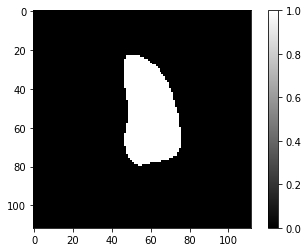

In [5]:
plt.imshow(segmentations[ed_index], cmap="gray")
plt.colorbar()

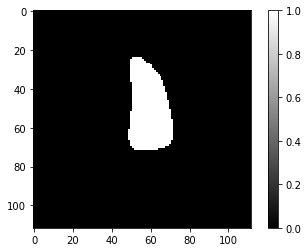

In [6]:
plt.imshow(segmentations[es_index], cmap="gray")
plt.colorbar()